In [1]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
(raw_train, raw_validation) , metadata= tfds.load('horses_or_humans', split=['train[:80%]', 'train[80%:100%]'], with_info=True, as_supervised=True)

In [3]:
print(raw_train)
print(raw_validation)

<DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>


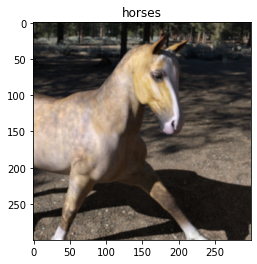

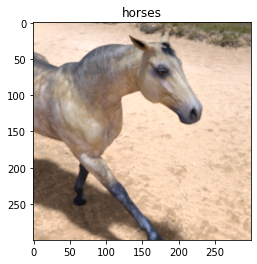

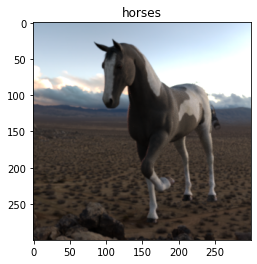

In [4]:
get_label_name= metadata.features['label'].int2str
for image, label in raw_train.take(3):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [5]:
IMG_SIZE= 160
def format_example(image,label):
  image=tf.cast(image, tf.float32)
  image=(image/127.5) - 1
  image=tf.image.resize(image,(IMG_SIZE, IMG_SIZE))
  return image, label

In [6]:
train=raw_train.map(format_example)
validation=raw_validation.map(format_example)


In [7]:
BATCH_SIZE= 32
SHUFFLE_BUFFER_SIZE= 1000
train_batches=train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches= validation.batch(BATCH_SIZE)


In [8]:
train_batches.output_shapes, validation_batches.output_shapes

Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


((TensorShape([None, 160, 160, 3]), TensorShape([None])),
 (TensorShape([None, 160, 160, 3]), TensorShape([None])))

In [9]:
for image_batch,label_batch in train_batches.take(1):
  pass
image_batch.shape


TensorShape([32, 160, 160, 3])

In [10]:
IMG_SHAPE=(IMG_SIZE, IMG_SIZE, 3)
base_model=tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False,weights='imagenet')

In [11]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [12]:

base_model.trainable= False

In [13]:
global_average_layer= tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average= global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [14]:
prediction_layer= tf.keras.layers.Dense(1)
prediction_batch=prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [15]:
model=tf.keras.Sequential([
      base_model,
      global_average_layer,
      prediction_layer
])

In [16]:
base_learning_rate= 0.00001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [18]:
initial_epochs=20

In [19]:
history=model.fit(train_batches, epochs=initial_epochs, validation_data=validation_batches)

Epoch 1/20
26/26 [==============================] - 3s 100ms/step - loss: 0.5499 - accuracy: 0.7859 - val_loss: 0.6300 - val_accuracy: 0.7268
Epoch 2/20
26/26 [==============================] - 2s 66ms/step - loss: 0.5297 - accuracy: 0.8041 - val_loss: 0.6071 - val_accuracy: 0.7366
Epoch 3/20
26/26 [==============================] - 2s 66ms/step - loss: 0.5121 - accuracy: 0.8151 - val_loss: 0.5858 - val_accuracy: 0.7512
Epoch 4/20
26/26 [==============================] - 2s 66ms/step - loss: 0.4956 - accuracy: 0.8248 - val_loss: 0.5658 - val_accuracy: 0.7805
Epoch 5/20
26/26 [==============================] - 2s 67ms/step - loss: 0.4795 - accuracy: 0.8321 - val_loss: 0.5463 - val_accuracy: 0.8098
Epoch 6/20
26/26 [==============================] - 2s 67ms/step - loss: 0.4641 - accuracy: 0.8418 - val_loss: 0.5284 - val_accuracy: 0.8098
Epoch 7/20
26/26 [==============================] - 2s 65ms/step - loss: 0.4493 - accuracy: 0.8540 - val_loss: 0.5106 - val_accuracy: 0.8244
Epoch 8/20
2

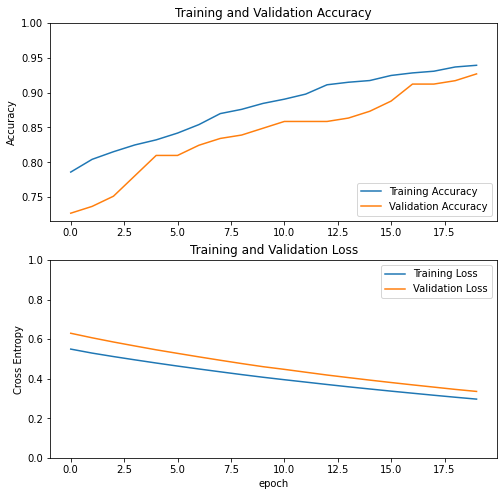

7/7 - 1s - loss: 0.3358 - accuracy: 0.9268

Test accuracy: 0.9268292784690857


In [20]:
#Evaluate the Model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
test_loss, test_acc = model.evaluate(validation_batches, verbose=2)
print('\nTest accuracy:', test_acc)

## FINE TUNING ##

In [21]:
base_model.trainable= True

In [22]:
print("Number of layers in the base model:",len(base_model.layers))

Number of layers in the base model: 155


In [23]:
fine_tune_at=115

In [24]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable= False

In [25]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits= True),optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,682,817
Non-trainable params: 576,448
_________________________________________________________________


In [27]:
fine_tune_epochs= 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,epochs=total_epochs, initial_epoch= history.epoch[-1], validation_data= validation_batches)


Epoch 20/30
26/26 [==============================] - 3s 99ms/step - loss: 0.4506 - accuracy: 0.7981 - val_loss: 0.2971 - val_accuracy: 0.9561
Epoch 21/30
26/26 [==============================] - 2s 74ms/step - loss: 0.4002 - accuracy: 0.8528 - val_loss: 0.2713 - val_accuracy: 0.9707
Epoch 22/30
26/26 [==============================] - 2s 73ms/step - loss: 0.3589 - accuracy: 0.8905 - val_loss: 0.2478 - val_accuracy: 0.9854
Epoch 23/30
26/26 [==============================] - 2s 73ms/step - loss: 0.3243 - accuracy: 0.9185 - val_loss: 0.2264 - val_accuracy: 0.9902
Epoch 24/30
26/26 [==============================] - 2s 73ms/step - loss: 0.2876 - accuracy: 0.9404 - val_loss: 0.2061 - val_accuracy: 0.9951
Epoch 25/30
26/26 [==============================] - 2s 73ms/step - loss: 0.2543 - accuracy: 0.9586 - val_loss: 0.1877 - val_accuracy: 0.9951
Epoch 26/30
26/26 [==============================] - 2s 73ms/step - loss: 0.2343 - accuracy: 0.9586 - val_loss: 0.1712 - val_accuracy: 0.9951
Epoch 

In [28]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

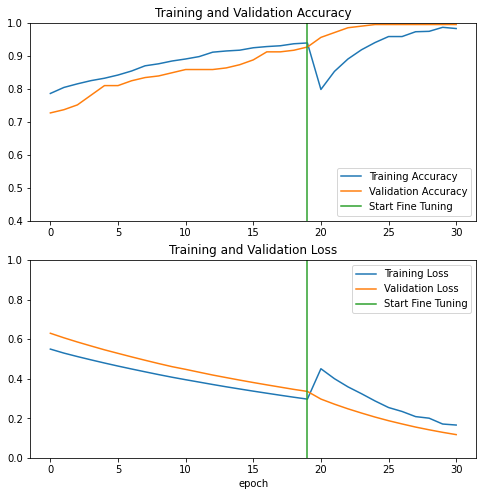

7/7 - 1s - loss: 0.1173 - accuracy: 0.9951

 Test accuracy: 0.995121955871582


In [29]:
#Evaluate the Model
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
test_loss, test_acc = model.evaluate(validation_batches, verbose=2)
print('\n Test accuracy:', test_acc)